In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 数据导入和预处理

In [2]:
# 读取数据
df = pd.read_csv('diabetes.csv')

# 检查数据的前几行
print(df.head())

# 基本的描述性统计
print(df.describe())

# 检查缺失值
print(df.isnull().sum())

# 计算特定列零值的个数
zero_counts = {col: df[df[col] == 0].shape[0] for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']}
print(zero_counts)

# 检查数据类型
print(df.dtypes)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   

In [3]:
# 用平均值替换零值
for col in zero_counts.keys():
    # 计算非零值的平均值
    mean_value = df[df[col] != 0][col].mean()
    # 替换零值
    df.loc[df[col] == 0, col] = mean_value

# 返回修改后的数据
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.686763      72.405184      29.153420  155.548223   
std       3.369578   30.435949      12.096346       8.790942   85.021108   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.202592      29.153420  155.548223   
75%       6.000000  140.250000      80.000000      32.000000  155.548223   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.457464                  0.471876   33.240885    0.348958  
std      6.875151                  0.331329   11.760232    0.476951  
min     18.200000                  

## 描述性统计

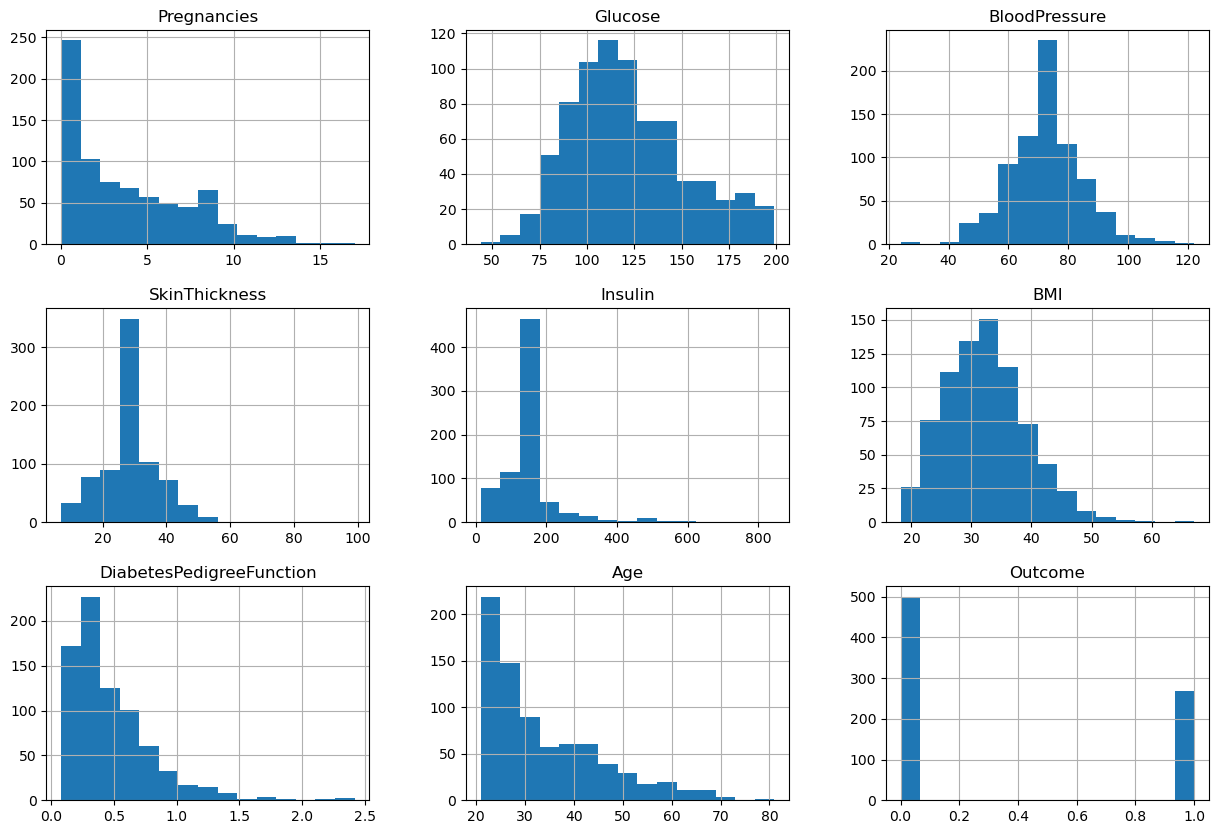

In [16]:
# 数据分布的可视化
df.hist(bins=15, figsize=(15, 10))
plt.show()

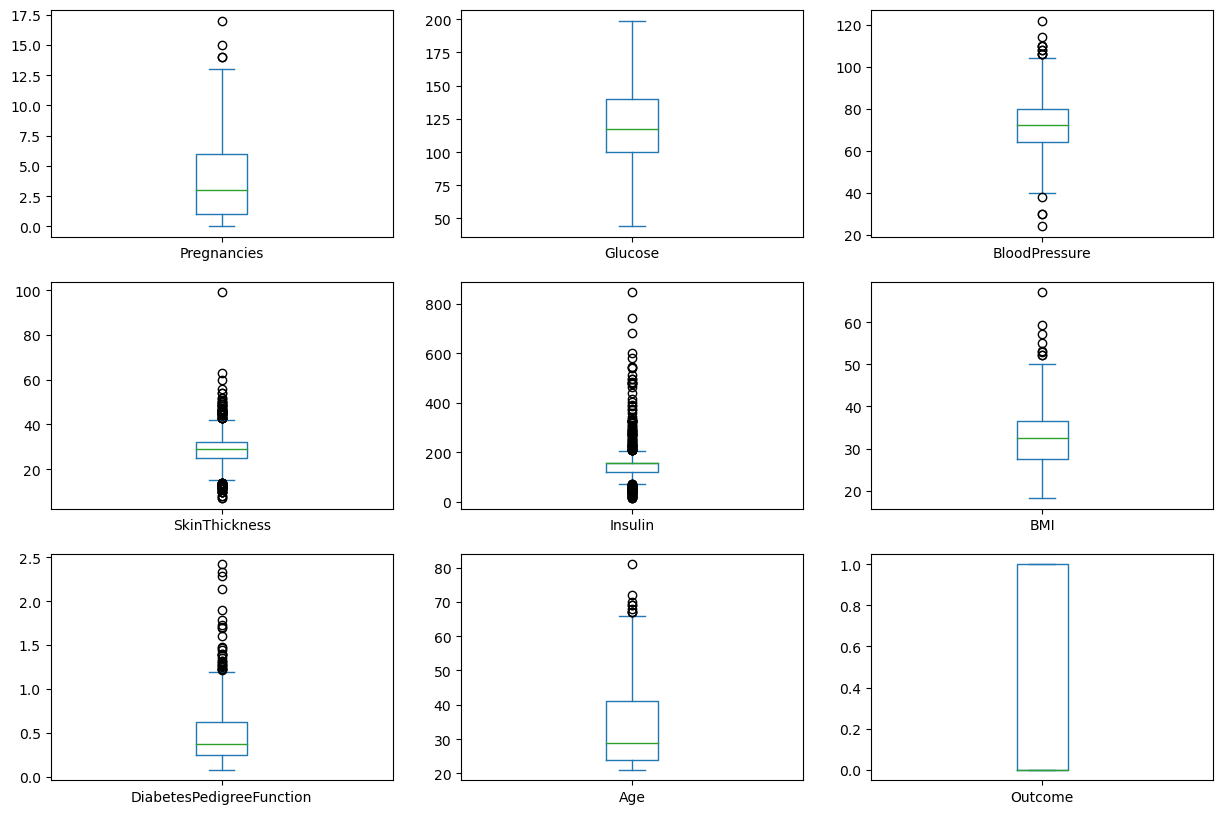

In [17]:
# 箱线图
df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(15,10))
plt.show()

In [18]:
# 类别分布
print(df['Outcome'].value_counts())

0    500
1    268
Name: Outcome, dtype: int64


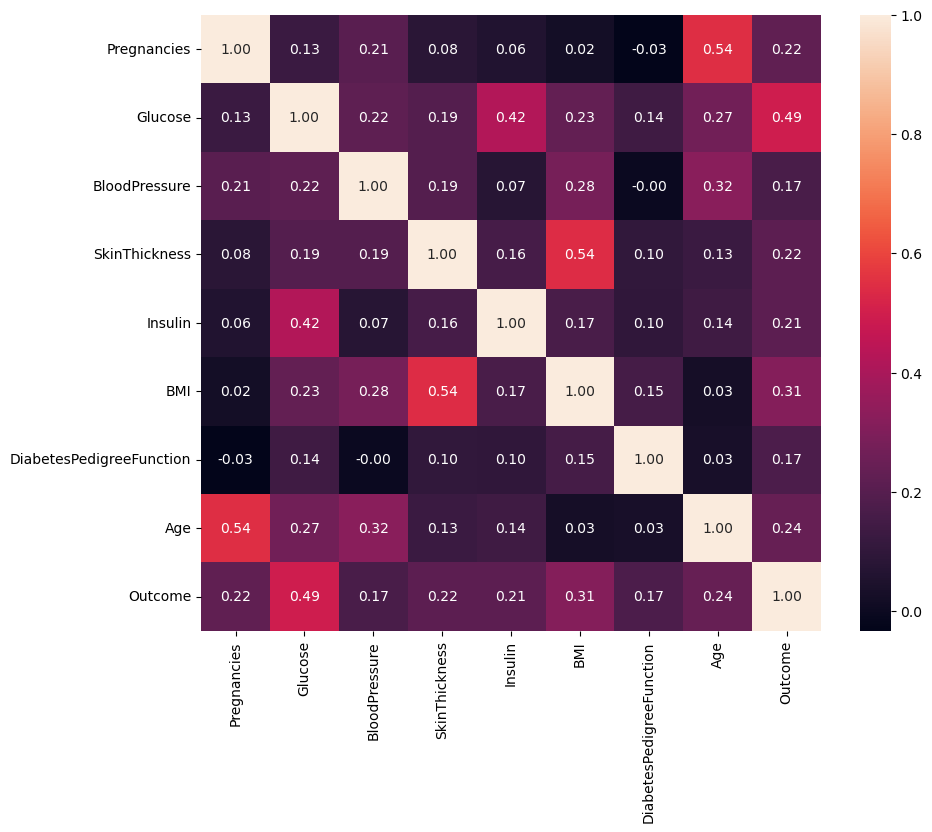

In [19]:
# 相关性分析
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

## 定义一个专门的类来封装数据处理和可视化的功能

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

In [ ]:
class ModelEvaluator:
    def __init__(self, data, k=5, random_state=1):
        self.data = data
        self.k = k
        self.random_state = random_state
        self.models = {
            'LDA': LinearDiscriminantAnalysis(),
            'QDA': QuadraticDiscriminantAnalysis(),
            'Logistic Regression': LogisticRegression(solver='liblinear'),
            'KNN': KNeighborsClassifier(),
            'Random Forest': RandomForestClassifier(random_state=self.random_state)
            # 'SVM': SVC()
        }
        self.results = {model: {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []} for model in self.models}

    def tune_hyperparameters(self, model_name, param_grid, param_count=2, cv=10):
        # 检查模型是否存在
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found in the available models.")
    
        model = self.models[model_name]
    
        try:
            # 检查参数网格中的参数是否有效
            valid_params = model.get_params().keys()
            for param in param_grid:
                if param not in valid_params:
                    raise ValueError(f"Invalid parameter '{param}' for estimator {model_name}. "
                                     f"Valid parameters are: {list(valid_params)}.")
    
            # 进行超参数调优
            grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', return_train_score=True)
            grid_search.fit(self.data.drop('Outcome', axis=1), self.data['Outcome'])
    
            # 更新模型为最优参数的模型
            self.models[model_name] = grid_search.best_estimator_
            print(f"Best parameters for {model_name}: {grid_search.best_params_}")
            print(f"Best cross-validation score: {grid_search.best_score_}")
    
            return grid_search.cv_results_
        except Exception as e:
            print(f"An error occurred during hyperparameter tuning for {model_name}: {e}")
            return None

    
    def plot_hyperparameter_tuning_results(self, cv_results, param_grid, param_count=2):
        try:
            df = pd.DataFrame(cv_results)
            param_names = list(param_grid.keys())
    
             # 如果参数个数为1，使用折线图
            if param_count == 1 and len(param_names) == 1:
                param = 'param_' + param_names[0]
                plt.figure(figsize=(8, 6))
                sns.lineplot(x=df[param], y=df['mean_test_score'], marker='o')
                # 在每个点上标注数值
                for i, score in enumerate(df['mean_test_score']):
                    plt.text(df[param][i], score, f'{score:.3f}', horizontalalignment='left')
                plt.title(f"Grid Search Scores ({param_names[0]})")
                plt.xlabel(param_names[0])
                plt.ylabel('Mean Test Score')
                plt.show()
    
            # 如果参数个数为2，使用热图
            elif param_count == 2 and len(param_names) == 2:
                param_1, param_2 = 'param_' + param_names[0], 'param_' + param_names[1]
                scores_matrix = pd.pivot_table(
                    df, values='mean_test_score', index=param_1, columns=param_2)
                plt.figure(figsize=(8, 6))
                sns.heatmap(scores_matrix, annot=True, fmt=".3f", cmap="viridis")
                plt.title(f"Grid Search Scores ({param_names[0]}, {param_names[1]})")
                plt.xlabel(param_names[1])
                plt.ylabel(param_names[0])
                plt.show()
    
            # 如果参数个数超过2，输出提示信息
            elif param_count > 2:
                print("More than 2 hyperparameters, visualization not supported for the current model.")
    
        except Exception as e:
            print(f"An error occurred while plotting hyperparameter tuning results: {e}")

    def evaluate_models(self):
        # 模型建立，交叉验证的思想训练模型
        kf = KFold(n_splits=self.k, shuffle=True, random_state=self.random_state)

        for train_index, test_index in kf.split(self.data):
            data_train = self.data.iloc[train_index]
            data_test = self.data.iloc[test_index]
            Outcome_test = self.data['Outcome'].iloc[test_index]

            for name, model in self.models.items():
                self.train_and_evaluate(model, data_train, data_test, Outcome_test, name)

    def train_and_evaluate(self, model, data_train, data_test, Outcome_test, model_name):
        try:
            model.fit(data_train.drop('Outcome', axis=1), data_train['Outcome'])
            predictions = model.predict(data_test.drop('Outcome', axis=1))
            tab = confusion_matrix(Outcome_test, predictions)

            accuracy = np.mean(predictions == Outcome_test)
            precision = tab[1, 1] / (tab[1, 1] + tab[0, 1])
            recall = tab[1, 1] / (tab[1, 1] + tab[1, 0])
            f1 = 2 * precision * recall / (precision + recall)

            self.results[model_name]['Accuracy'].append(accuracy)
            self.results[model_name]['Precision'].append(precision)
            self.results[model_name]['Recall'].append(recall)
            self.results[model_name]['F1'].append(f1)
        except Exception as e:
            print(f"Error in training {model_name}: {e}")

    def plot_model_performance(self, model_name):
        try:
            if model_name not in self.results:
                print(f"Model {model_name} not found.")
                return
    
            metrics = self.results[model_name]
            metrics_df = pd.DataFrame(metrics)
    
            fig, ax = plt.subplots(figsize=(10, 6))
            x = np.arange(len(metrics_df.columns))
            bar_width = 0.15
    
            for i in range(metrics_df.shape[0]):
                ax.bar(x + i * bar_width, metrics_df.iloc[i], bar_width, label=f'Test Set {i+1}')
    
            mean_values = metrics_df.mean()
            ax.plot(x + bar_width * 2, mean_values, color='black', marker='o', linestyle='-', linewidth=2, label='Mean CV Score')
    
            for i, mean in enumerate(mean_values):
                ax.text(x[i] + bar_width * 2, mean, f'{mean:.3f}', ha='center', va='bottom')
    
            ax.set_xlabel('Metric')
            ax.set_xticks(x + bar_width * 2)
            ax.set_xticklabels(metrics_df.columns)
            ax.set_title(f"{model_name} Performance")
            ax.legend()
    
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"An error occurred while plotting model performance for {model_name}: {e}")


    def plot_mean_cv_scores(self):
        try:
            fig, ax = plt.subplots(figsize=(10, 6))
            metrics_names = list(self.results[next(iter(self.results))].keys())
            x = np.arange(len(metrics_names))
    
            for model_name, metrics in self.results.items():
                mean_values = [np.mean(metrics[metric]) for metric in metrics_names]
                ax.plot(x, mean_values, marker='o', linestyle='-', linewidth=2, label=f'{model_name} Mean CV Score')
    
            ax.set_xticks(x)
            ax.set_xticklabels(metrics_names)
            ax.set_title('Mean CV Scores Across Models')
            ax.set_xlabel('Metric')
            ax.legend()
    
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"An error occurred while plotting mean CV scores across models: {e}")

        
    

### 访问并修改类中的参数

In [144]:
evaluator = ModelEvaluator(data)
print(evaluator.k)
# evaluator.k = 10
# print(evaluator.k)
print(evaluator.models)

5
{'LDA': LinearDiscriminantAnalysis(), 'QDA': QuadraticDiscriminantAnalysis(), 'Logistic Regression': LogisticRegression(solver='liblinear'), 'KNN': KNeighborsClassifier(), 'Random Forest': RandomForestClassifier(random_state=1)}


### 调参前模型对比

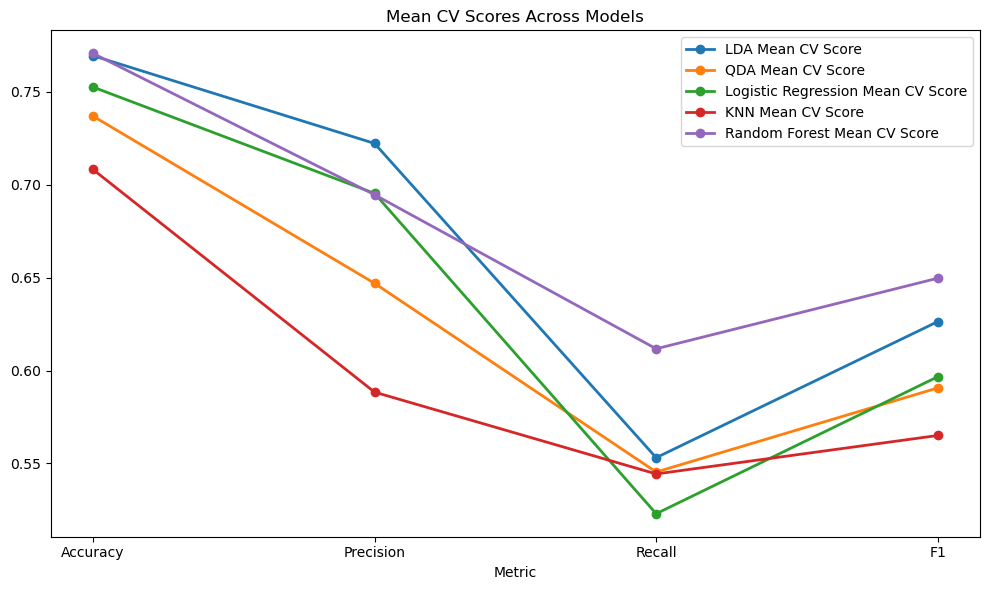

In [145]:
# 调参前
evaluator.evaluate_models()
evaluator.plot_mean_cv_scores()

In [126]:
evaluator.results

{'LDA': {'Accuracy': [0.7662337662337663,
   0.7532467532467533,
   0.7727272727272727,
   0.803921568627451,
   0.7516339869281046],
  'Precision': [0.7317073170731707,
   0.6904761904761905,
   0.725,
   0.75,
   0.7142857142857143],
  'Recall': [0.5454545454545454,
   0.5370370370370371,
   0.5471698113207547,
   0.6,
   0.5357142857142857],
  'F1': [0.6249999999999999,
   0.6041666666666667,
   0.6236559139784946,
   0.6666666666666665,
   0.6122448979591837]},
 'QDA': {'Accuracy': [0.7792207792207793,
   0.7272727272727273,
   0.6818181818181818,
   0.7516339869281046,
   0.7450980392156863],
  'Precision': [0.7441860465116279,
   0.6363636363636364,
   0.5454545454545454,
   0.62,
   0.6888888888888889],
  'Recall': [0.5818181818181818,
   0.5185185185185185,
   0.4528301886792453,
   0.62,
   0.5535714285714286],
  'F1': [0.6530612244897959,
   0.5714285714285714,
   0.49484536082474223,
   0.62,
   0.6138613861386139]},
 'Logistic Regression': {'Accuracy': [0.7727272727272727,


### 单个模型的表现，以KNN为例

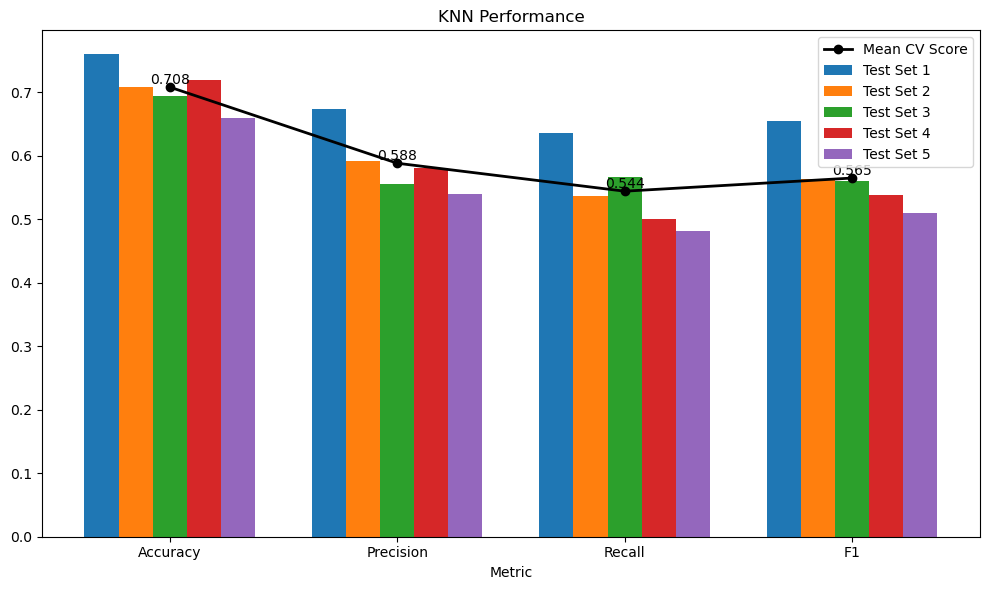

In [147]:
evaluator.plot_model_performance('KNN')

In [148]:
evaluator.models['KNN'].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

### 模型调参

Best parameters for LDA: {'solver': 'lsqr'}
Best cross-validation score: 0.7669514695830485


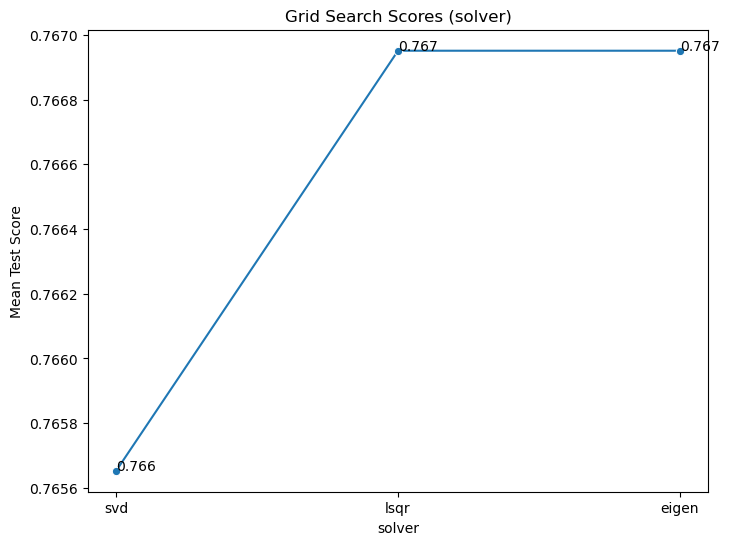

In [149]:
# LDA
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
}
evaluator = ModelEvaluator(data)
cv_results = evaluator.tune_hyperparameters('LDA', param_grid_lda, 1)
evaluator.plot_hyperparameter_tuning_results(cv_results, param_grid_lda, 1)

Best parameters for QDA: {'reg_param': 0.1}
Best cross-validation score: 0.7448564593301434


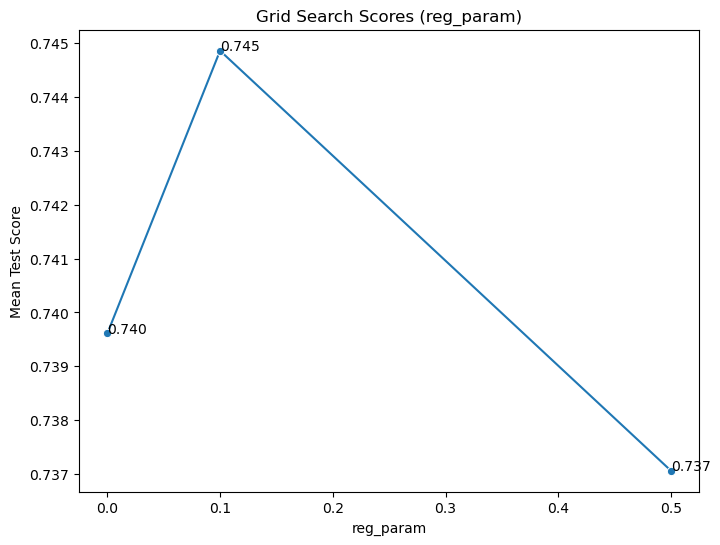

In [150]:
# QDA
param_grid_qda = {'reg_param': [0, 0.1, 0.5]}
cv_results_qda = evaluator.tune_hyperparameters('QDA', param_grid_qda, param_count=1)
evaluator.plot_hyperparameter_tuning_results(cv_results_qda, param_grid_qda, param_count=1)

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1'}
Best cross-validation score: 0.7695659603554341


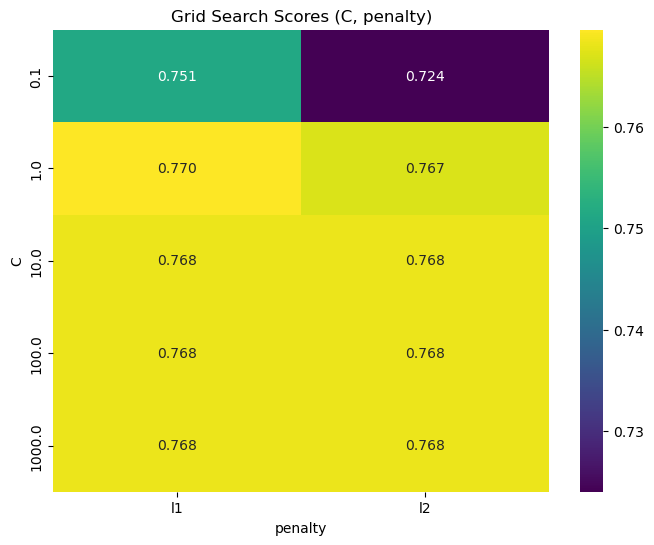

In [151]:
# 对logistics模型调参
param_grid_logistics = {
    'C': [0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2']
}

evaluator = ModelEvaluator(data)
cv_results = evaluator.tune_hyperparameters('Logistic Regression', param_grid_logistics)
evaluator.plot_hyperparameter_tuning_results(cv_results, param_grid_logistics)

Best parameters for KNN: {'n_neighbors': 13, 'weights': 'uniform'}
Best cross-validation score: 0.7410287081339714


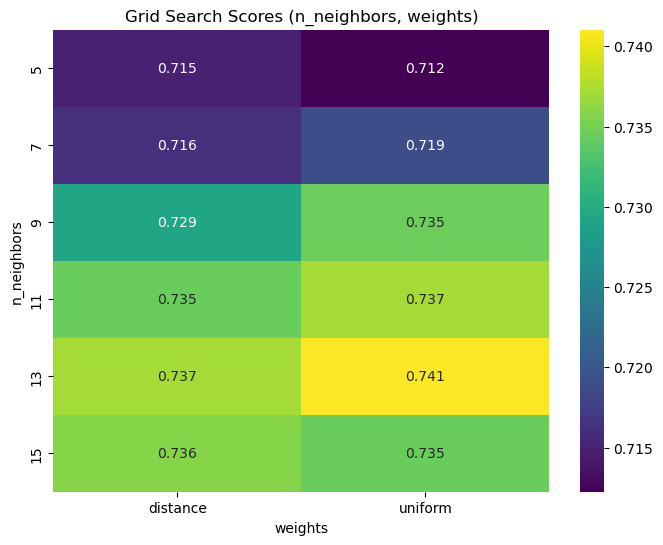

In [152]:
# KNN
param_grid_knn = {'n_neighbors': [5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']}
cv_results_knn = evaluator.tune_hyperparameters('KNN', param_grid_knn, param_count=2)
evaluator.plot_hyperparameter_tuning_results(cv_results_knn, param_grid_knn, param_count=2)

In [153]:
# SVM
# param_grid_svm = {'C': [1, 10, 100], 'kernel': ['linear', 'rbf']}
# cv_results_svm = evaluator.tune_hyperparameters('SVM', param_grid_svm, param_count=2)
# evaluator.plot_hyperparameter_tuning_results(cv_results_svm, param_grid_svm, param_count=2)

In [154]:
# Random Forest with 3 parameters
param_grid_rf = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 4, 6]}
cv_results_rf = evaluator.tune_hyperparameters('Random Forest', param_grid_rf, param_count=3)
evaluator.plot_hyperparameter_tuning_results(cv_results_rf, param_grid_rf, param_count=3)

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.7669002050580997
More than 2 hyperparameters, visualization not supported for the current model.


### 调参后模型的对比

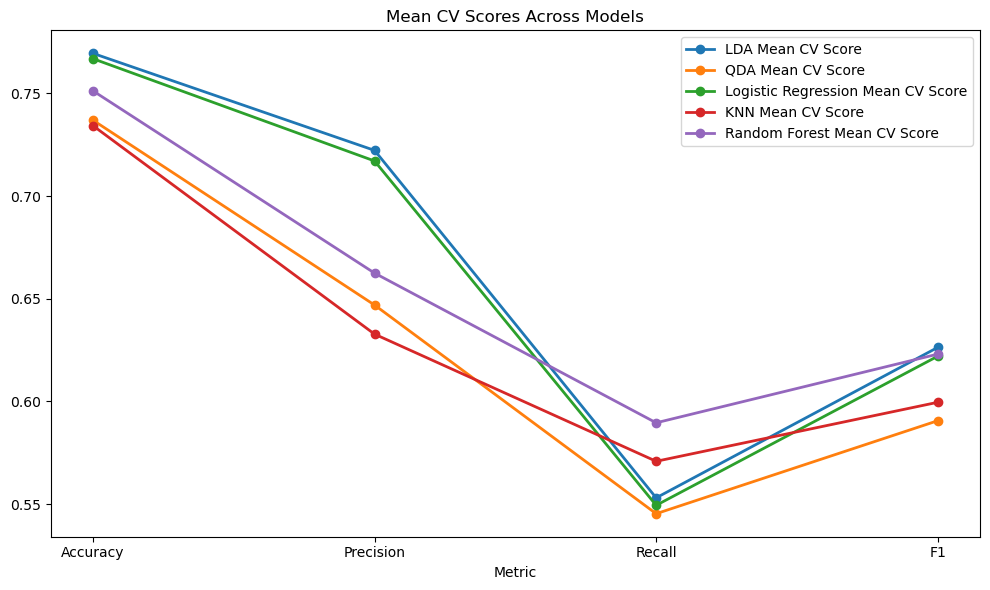

In [155]:
# 调参后
evaluator.evaluate_models()
evaluator.plot_mean_cv_scores()

In [156]:
evaluator.results

{'LDA': {'Accuracy': [0.7662337662337663,
   0.7532467532467533,
   0.7727272727272727,
   0.803921568627451,
   0.7516339869281046],
  'Precision': [0.7317073170731707,
   0.6904761904761905,
   0.725,
   0.75,
   0.7142857142857143],
  'Recall': [0.5454545454545454,
   0.5370370370370371,
   0.5471698113207547,
   0.6,
   0.5357142857142857],
  'F1': [0.6249999999999999,
   0.6041666666666667,
   0.6236559139784946,
   0.6666666666666665,
   0.6122448979591837]},
 'QDA': {'Accuracy': [0.7792207792207793,
   0.7272727272727273,
   0.6818181818181818,
   0.7516339869281046,
   0.7450980392156863],
  'Precision': [0.7441860465116279,
   0.6363636363636364,
   0.5454545454545454,
   0.62,
   0.6888888888888889],
  'Recall': [0.5818181818181818,
   0.5185185185185185,
   0.4528301886792453,
   0.62,
   0.5535714285714286],
  'F1': [0.6530612244897959,
   0.5714285714285714,
   0.49484536082474223,
   0.62,
   0.6138613861386139]},
 'Logistic Regression': {'Accuracy': [0.7727272727272727,


### 调参后模型的表现，以KNN为例

In [135]:
evaluator.models['KNN'].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 13,
 'p': 2,
 'weights': 'distance'}

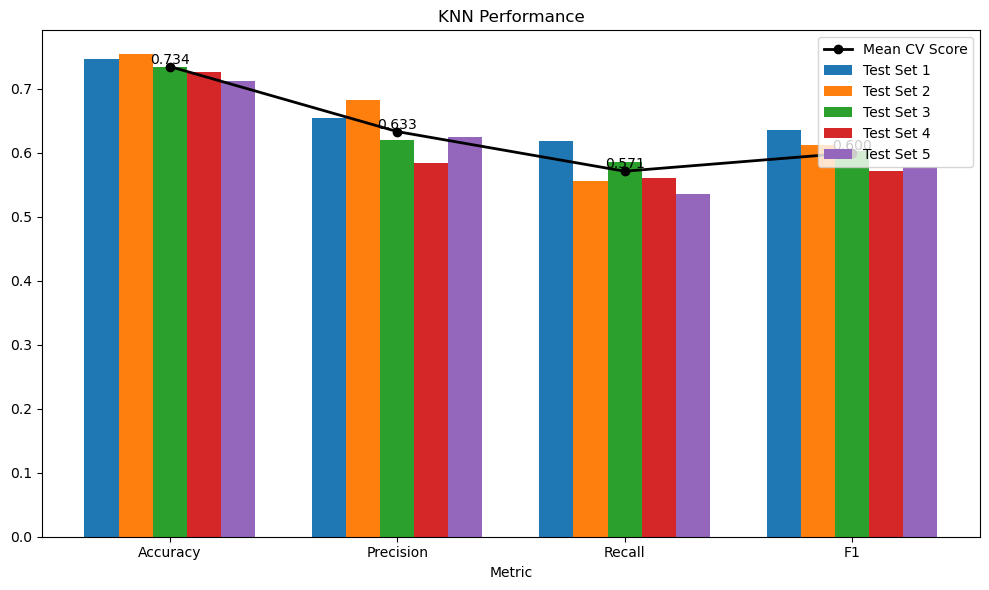

In [157]:
evaluator.plot_model_performance('KNN')